# Yelp Dataset Challenge Week 2

2/25/2017 - 3/4/2017
### Overview
Aiming to create a user time series network and see how the community of user develop over time. 

In [1]:
import csv
import json
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt


# Opening json file and create the dictionary of array
business=[]
with open('../src/yelp_academic_dataset_business.json') as json_file:
    for line in json_file:
        business.append(json.loads(line))
        
len(business)

144072

Read the json file line by line, load the line into python dictionary. (This took a while)

In [4]:
user = []
with open('../src/yelp_academic_dataset_user.json') as json_file:
    counter = 0
    for line in json_file:
        counter +=1
        # counter because I became nervous
        if counter % 100000 == 0:
            print(counter)
        user.append(json.loads(line))
len(user)

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000


1029432

Now we want to create a user network data with time variables. First we need to prepare data structure that stores only relevant information.

In [5]:
# peek the list
user[0].keys()

[u'yelping_since',
 u'useful',
 u'compliment_photos',
 u'compliment_list',
 u'compliment_funny',
 u'funny',
 u'review_count',
 u'friends',
 u'fans',
 u'type',
 u'compliment_note',
 u'compliment_plain',
 u'compliment_writer',
 u'compliment_cute',
 u'average_stars',
 u'user_id',
 u'compliment_more',
 u'elite',
 u'compliment_hot',
 u'cool',
 u'name',
 u'compliment_profile',
 u'compliment_cool']

Since the dataset with very large, I took 10000 samples from userdata and collected 'yelpsince' attributes.

In [6]:
import pandas as pd
import random
# extract all user id and the date they joined
date = []
user_id = []

# take 10000 random sample of the data 
rnd_idx = random.sample(xrange(0,len(user)), 10000)

for i in rnd_idx:
    date.append(user[i].get('yelping_since'))
    user_id.append(user[i].get('user_id'))

len(date)

10000

In [7]:
# Create a pandas.DataFrame
time_df = pd.DataFrame({
    'ID': pd.Series(user_id), 'DATE': pd.Series(date)})
time_df.head()

,DATE,ID
0,2014-06-09,sb_3fwK2YOCWWJRTGQaJhQ
1,2015-09-29,8meRocPudF7A3SAvX-p8Cw
2,2011-10-05,4eROpHOL2D_YFr4hdml-kQ
3,2012-05-25,RI-Nc2S7GbVVOkxmIyE2yg
4,2016-03-22,MfLW6qgg3LfLzsh9K5ZjYA


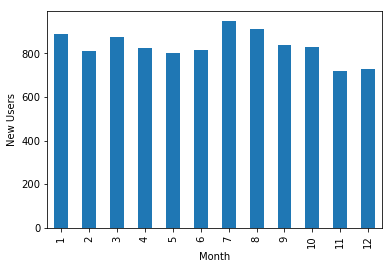

In [8]:
import numpy as np

# month vs new users
time_df['DATE'].groupby(time_df['DATE'].astype("datetime64").dt.month).count().plot(kind="bar")
plt.xlabel('Month')
plt.ylabel('New Users')
plt.show()

There is no correlation between month of the year and the amount of new users

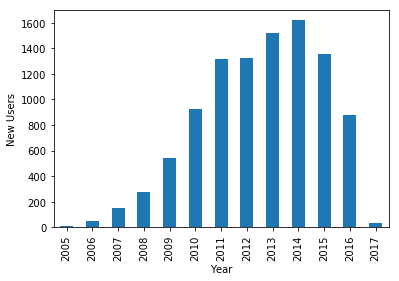

In [9]:
# Year vs amount of new users
plt.clf()
time_df['DATE'].groupby(time_df['DATE'].astype("datetime64").dt.year).count().plot(kind="bar")
plt.xlabel('Year')
plt.ylabel('New Users')
plt.show()

Interesting enough, the amount of new users has been declining after peaking at 2014.

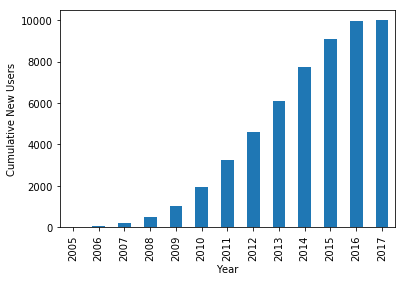

In [10]:
plt.clf()
time_df['DATE'].groupby([time_df['DATE'].astype("datetime64").dt.year]).count().cumsum().plot(kind="bar")
plt.xlabel('Year')
plt.ylabel('Cumulative New Users')
plt.show()

The growth of Yelp peaked after 2014 and entered stable time period since 2015

In [11]:
# Make a list of all users who joined between 2004 - 2005
def get_pre_user(year):
    ''' Extract user info who has been on yelp since input year '''
    user_id =[]
    for i in range(len(user)):
        time = str(user[i].get('yelping_since'))
        uyear = time.split('-')[0]
        if int(uyear) <= year:
            user_id.append(user[i].get('user_id'))
    return user_id

test = get_pre_user(2005)
print(len(test))

1012


In [12]:
# Collect the list of friends corresponding with the list I aquired above
def get_friends_from(ids):
    '''extract the list of friends id who has been using Yelp since 2005'''
    friends = []
    count = 0
    for u in user:
        if (u['user_id'] in ids):
            count +=1 
            friends.append(filter(lambda d: d in ids, u['friends']))
    print(count)
    return friends

friends = get_friends_from(test)

1012


There are only 1012 subset of users who joined before 2006

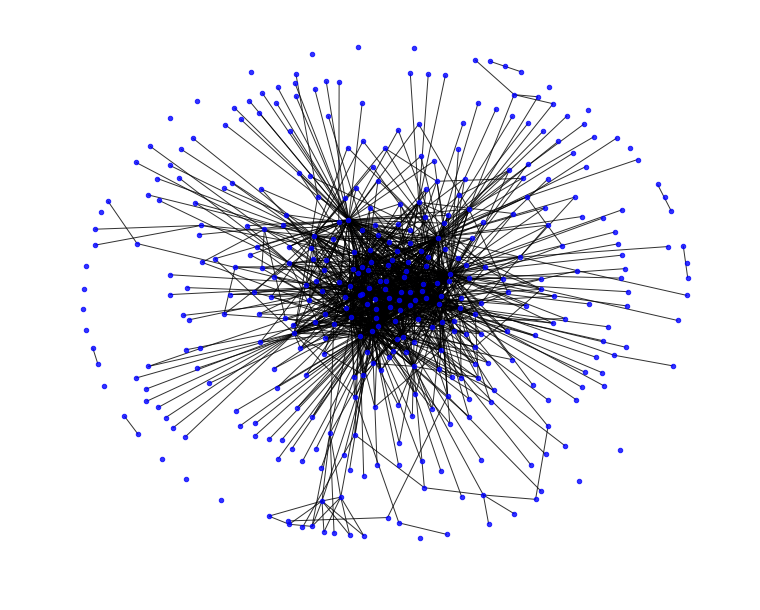

In [14]:
# Create a user network graph using networkx library
import networkx as nx

def create_graph(users, friends):
    user_net = nx.Graph()
    for i in range(len(users)):
        user_net.add_node(users[i])
    for i in range(len(friends)):
        for j in range(len(friends[i])):
            user_net.add_edge(users[i], friends[i][j])
            # print(users[i], friends[i][j])
    plt.figure(figsize=(10,8))
    nx.draw(user_net, node_color='b', node_size=20, alpha=0.8)
    plt.show()

create_graph(test[0:100], friends[0:100])

Took the first 100 users from the subset I created (based on visualization purpose). Found out that the user network is centralized by a small community of users who have large amount of friends and there are also a fair amount of users who do not have any friends or perhaps 1.

Decided to investigate more on the skewness in the amount of degree from each edge.

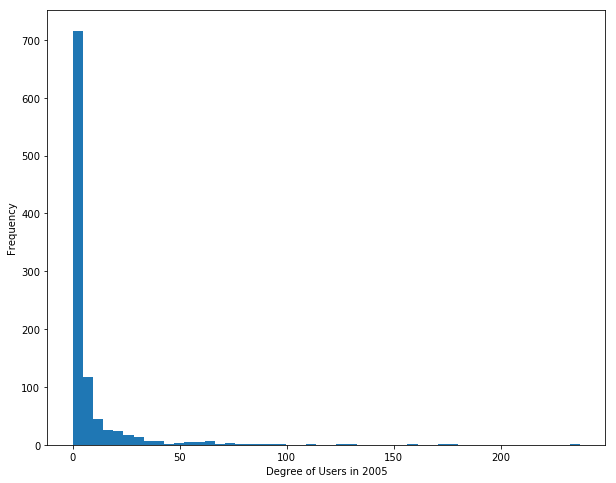

355 users with < 1 friends in 2005
517 users with < 2 friends in 2005
Max Degree: 237


In [15]:
# Create a histgram of the degrees of users in 2005
plt.close()
degrees = map(len, friends)
plt.figure(figsize = (10,8))
plt.hist(degrees, bins = 50)

plt.xlabel('Degree of Users in 2005')
plt.ylabel('Frequency')
plt.show()

# Number of nodes with the degree of 0
degrees = np.asarray(degrees)
print(str(len(np.where(degrees == 0)[0])) + " users with < 1 friends in 2005") # 355

# Number of nodes with the degree less than 2
print(str(len(np.where(degrees <= 1)[0])) + " users with < 2 friends in 2005") # 517

# Max num of degree by 1 user
print("Max Degree: "+ str(degrees.max()))

Further investigate on this using the users from all years

In [16]:
# user degrees of all years
user_degrees = []
for i in range(len(user)):
    user_degrees.append(len(user[i]['friends']))

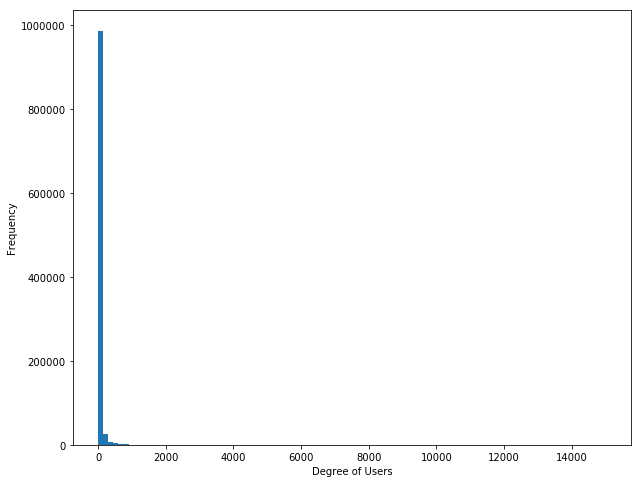

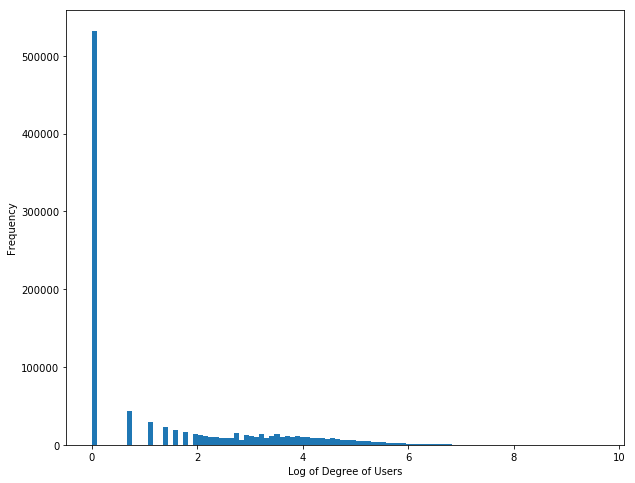

Max degrees: 14995
Min degrees: 1


In [17]:
# Create a histogram of degrees and users in all years
import math

user_degrees = np.asarray(user_degrees)

log_degrees = map(math.log,user_degrees)

# histogram between degrees and frequency
plt.figure(figsize = (10,8))
plt.hist(user_degrees, bins = 100)
plt.xlabel('Degree of Users')
plt.ylabel('Frequency')

# Log graph
plt.figure(figsize = (10,8))
plt.hist(log_degrees, bins = 100)
plt.xlabel('Log of Degree of Users')
plt.ylabel('Frequency')

plt.show()
plt.close
print("Max degrees: " + str(max(user_degrees)))
print("Min degrees: " + str(min(user_degrees)))

In [17]:
# Sort the user_degrees and peak the last 100 entries of the array
user_degrees.sort()
user_degrees[len(user_degrees)-50:]

array([ 5690,  5691,  5695,  5711,  5716,  5718,  5725,  5737,  5746,
        5772,  5791,  5799,  5807,  5834,  5874,  5881,  5886,  5891,
        5913,  5943,  5964,  5988,  6006,  6035,  6093,  6275,  6322,
        6352,  6360,  6400,  6515,  6559,  6623,  6682,  6711,  6750,
        6850,  7072,  7104,  7300,  7331,  7723,  7754,  7818,  7847,
        7885,  7932,  7997, 12085, 14995])

There are 2 obvious outliers in the dataset. 2 users with 12085 and 14995 friends in Yelp. Probably they don't have friends in real life.

In [18]:
# Check how many users have less than 2 friends (1 or 0)
len(user_degrees[np.where([(user_degrees < 2)])[1]])

532340

Supprisingly more than half users don't have friends or only have 1.

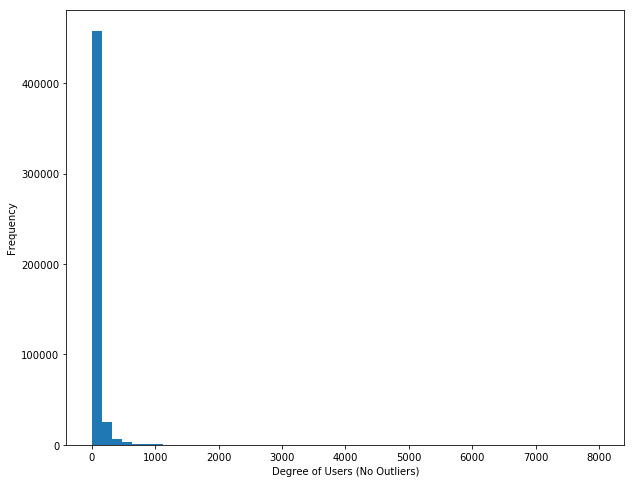

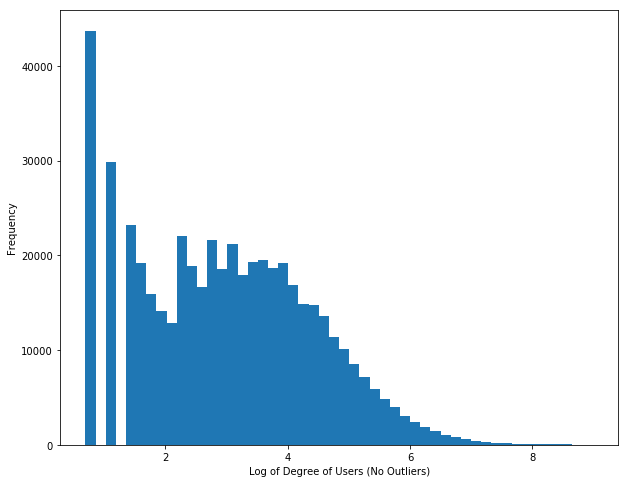

In [19]:
# Remove 2 extreme cases and users with single friend

# Create 2 histograms
processed_degrees = user_degrees[np.where([(user_degrees > 1)&(user_degrees < 12000)])[1]]

log_processed_degrees = map(math.log,processed_degrees)

plt.close
plt.figure(figsize = (10,8))
plt.hist(processed_degrees, bins = 50)
plt.xlabel('Degree of Users (No Outliers)')
plt.ylabel('Frequency')

plt.close
plt.figure(figsize = (10,8))
plt.hist(log_processed_degrees, bins = 50)
plt.xlabel('Log of Degree of Users (No Outliers)')
plt.ylabel('Frequency')

plt.show()

After this initial analysis I found following information that can be helpful for the network analysis.
* The degree among nodes is extremely skewed
* There are 2 outliers that have extreme number of friends

I presume that we can make a simple community analysis on the user network graph by combining the nodes whose degree is lower than the threshold value.
We are going to increase this threshold value until the subgraph becomes disjointed and declare them as the community of users.

In [58]:
# User node class (Tree)
class UserNode():
    def __init__(self, user_id):
        self.user_id = user_id
        self.comunity = 0
        self.children = []
        
    def set_community(self, com):
        self.community = com
    
    def get_children(self):
        print(self.children)
        
    def set_child(self, child):
        self.children.append(child)

In [54]:
# creates a dictionary {[user_id]:idx} for the better time complexity in the future
user_dict = {}
for i in range(len(user)):
    uid = user[i]['user_id']
    user_dict[uid] = i

In [22]:
len(user_dict)
user_dict.keys()[0:5]

[u'8uU9PRtwgHrSDtve7Z-sMA',
 u'an8MLCN3dYT8J6eSaszWlw',
 u'TSFDRxY6Fvb8o9ylq-9Jzg',
 u'Bu1-Nm7zPbWRf14RSCIi6Q',
 u'loLuBrbsKuWJ-uEvV3ZBRg']

In [77]:
# function to find the number of users in the community
def population(node):
    if (len(node.children) == 0):
        return 1
    else:
        ans = 1
        for t in node.children:
            ans += population(t)
        return ans
    
# Now use subset of users who have been on Yelp since 2005
def network(users, iteration):
    '''
    users: array of user id
    iteration: how many loops they continue
    '''
    # Initialize graph, O(n)
    user_net = nx.Graph()
    for i in users:
        user_net.add_node(i) 
    print("Initialized graph")
    
    # Initialize available user batch
    available = list(users)
    
    # Initialize the dictionary of usernodes, key is the id
    user_nodes = {}
    
    for i in users:
        user_nodes[i] = UserNode(i)
    print("Initialized UserNodes class")
    
    # dictionary of community, key is the id of parent node
    community = {}
    
    # main iteration
    count = 0
    while(count < iteration):
        for u in available:
            index = user_dict[u]
            fs = []
            # check friends in available user batch
            
            for f in (user[index]['friends']):
                if (f in available):
                    fs.append(f)
            # if no friends 
            if (len(fs) == 0):
                # if the user has a child, add to community
                if (len(user_nodes[u].children) != 0):
                    available.remove(u)
                    community[u] = (user_nodes[u], population(user_nodes[u]))
                    user_net.remove_node(u)
                else:
                # else delete this person (floating node)
                    available.remove(u)
                    user_net.remove_node(u)
                   
            # if 1 friends
            elif (len(fs) == 1):
                available.remove(u)
                user_net.remove_node(u)
                parent = user_nodes[fs[0]]
                parent.set_child(user_nodes[u])
            else:
                for e in fs:
                    user_net.add_edge(u,e)
        count += 1
    return community, user_net, user_nodes

In [78]:
user_2005 = list(test)
com, net, nodes = network(user_2005,5)

Initialized graph
Initialized UserNodes class


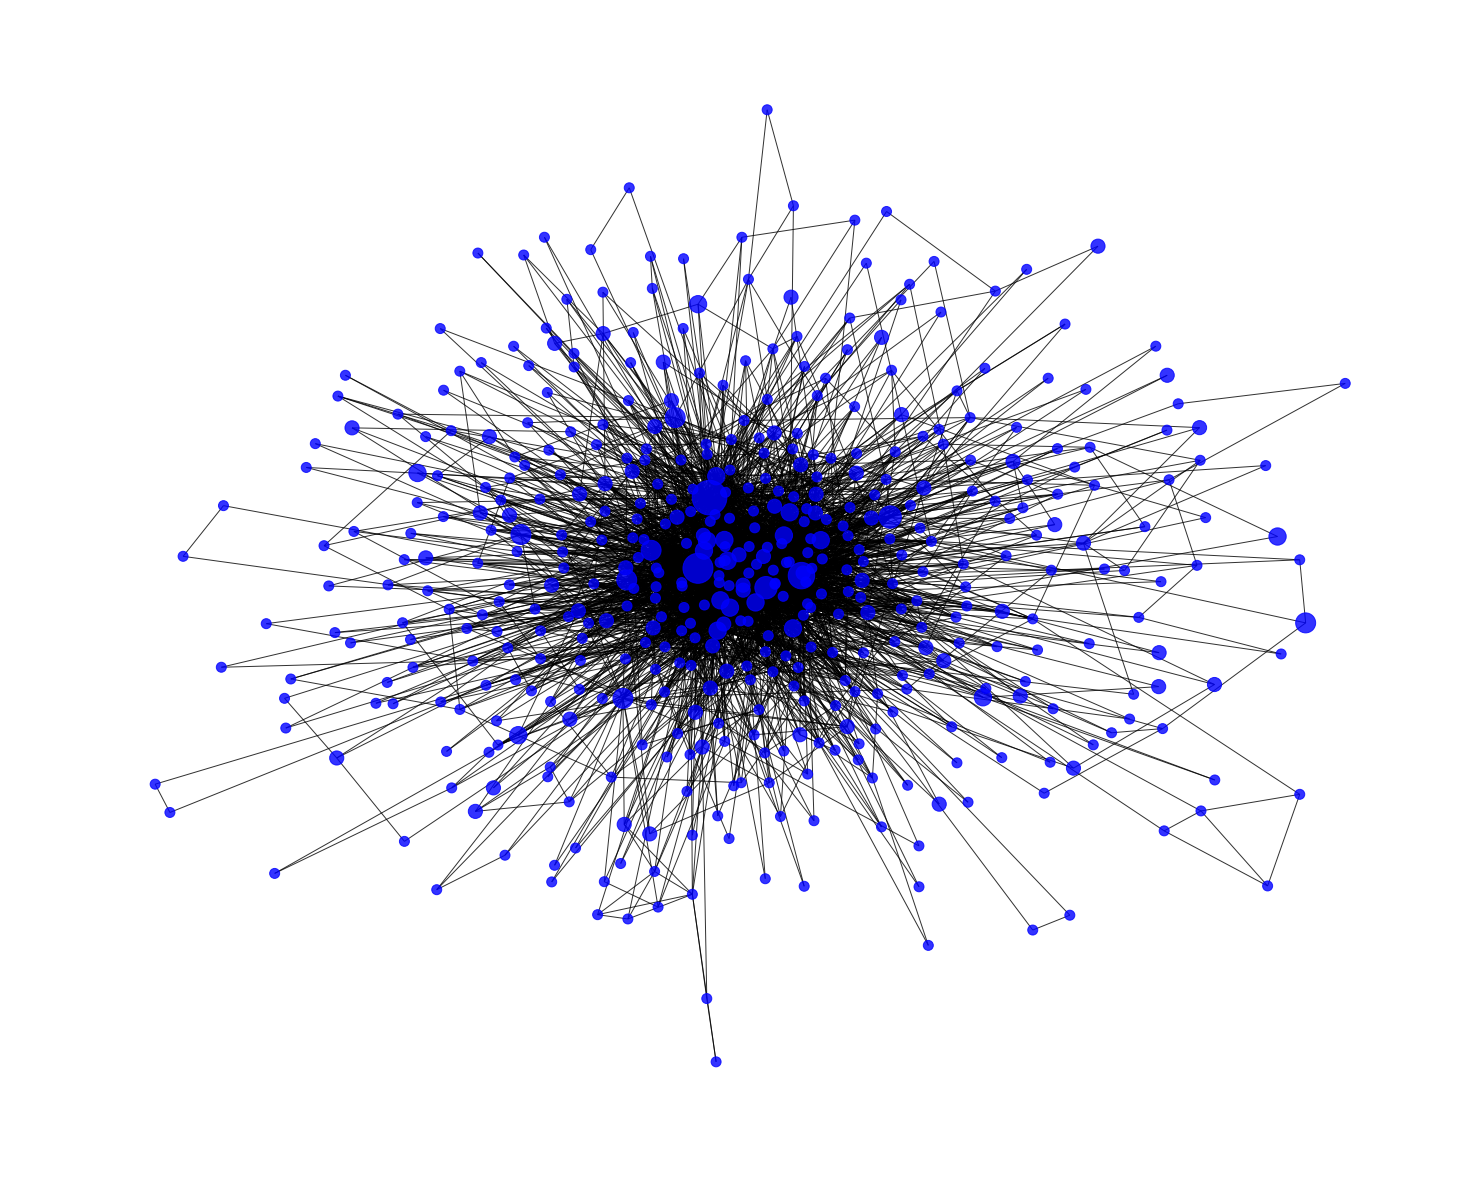

In [87]:
# change radius by the size of children
size = []
for n in net.nodes():
    size.append(100*population(nodes[n]))

plt.close()
plt.figure(figsize=(20,16))
nx.draw(net, node_color='b', node_size=size, alpha=0.8)
plt.show()

In [88]:
partition = 

ImportError: No module named community